# K-Nearest Neighbours (KNN) from scratch!

Given:
    
    X: a numpy array of shape mxn, m being the number of rows and n being the number of features
    Y: Y of shape mx1 (which is not needed for PCA

In [1]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode
import random

# Load the breast cancer dataset
cancer = load_breast_cancer()
X_cancer = cancer['data']
y_cancer = cancer['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42)

X_train_mu = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train_normalized = (X_train - X_train_mu) / X_train_std
X_test_normalized = (X_test - X_train_mu ) / X_train_std

### First, we have to calculate the distance between the data point and each data point in our training corpus.
### There are multiple distance measures:

#### Euclidean:
$$
d(p,q) = \sqrt{\sum_{i=1}^{n}{(q_i - p_i)^2}}
$$

In [2]:
def euclidean_0(p, q):
    # p and q are both of shape 1, n
    total = 0
    for i in range(len(p)):
        total += (p[i] - q[i]) ** 2
    return total

def euclidean_1(p, q):
    # p and q are both of shape 1, n
    p, q = np.array(p), np.array(q)
    return np.sqrt(np.sum((p - q) ** 2))

def euclidean_2(X, q):
    # X is of shape m, n and q is of shape 1, n
    if X.ndim > 2:
        raise ValueError("X has more than 2 dimensions.")
    q = q.reshape(1, -1)
    m, n = X.shape
    Q = np.repeat(q, m, axis=0) # now has shape m, n; works even without this line
    dist = np.sqrt(np.sum((X - Q) ** 2, axis=1))
    return dist.reshape(-1, 1) # returns shape m, 1

def euclidean_3(X, q):
    """
    Compute the Euclidean distance between each row of a 2-D array and a 1-D point.
    
    Parameters:
    X : 2-D array of shape (m, n)
    q : 1-D array of shape (n,)
    
    Returns:
    dist : 1-D array of shape (m,)
        The Euclidean distance between each row of X and q.
    """
    if X.ndim > 2:
        raise ValueError("X has more than 2 dimensions.")
    return np.sqrt(np.sum((X - q) ** 2, axis=1))

In [3]:
# Define test data
p = np.random.rand(50)
q = np.random.rand(50)
X = np.random.rand(1000, 50)

# Test euclidean_0
print("Testing euclidean_0...")
%timeit -n 100 [euclidean_0(x, q) for x in X]

# Test euclidean_1
print("\nTesting euclidean_1...")
%timeit -n 100 [euclidean_1(x, q) for x in X]

# Test euclidean_2
print("\nTesting euclidean_2...")
%timeit -n 100 euclidean_2(X, q)

# Test euclidean_3
print("\nTesting euclidean_3...")
%timeit -n 100 euclidean_3(X, q)

Testing euclidean_0...
28.1 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing euclidean_1...
8.85 ms ± 463 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing euclidean_2...
103 µs ± 4.16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing euclidean_3...
98.9 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Manhattan:
$$
d(p,q) = \sum_{i=1}^{n}{|p_i - q_i|}
$$

In [4]:
def manhattan_0(p, q):
    total = 0
    for i in range(len(p)):
        total += abs(p[i] - q[i])
    return total

def manhattan_1(p, q):
    p, q = np.array(p), np.array(q)
    return np.sum(np.abs(p - q))

def manhattan_2(X, q):
    if X.ndim > 2:
        raise ValueError("X has more than 2 dimensions.")
    m, n = X.shape
    q = q.reshape(1, -1)
    Q = np.repeat(q, m, axis=0)
    dist = np.sum(np.abs(X - Q), axis=1)
    return dist.reshape(-1, 1)

def manhattan_3(X, q):
    """
    Compute the Manhattan distance between each row of a 2-D array and a 1-D point.
    
    Parameters:
    X : 2-D array of shape (m, n)
    q : 1-D array of shape (n,)
    
    Returns:
    dist : 1-D array of shape (m,)
        The Manhattan distance between each row of X and q.
    """
    if X.ndim > 2:
        raise ValueError("X has more than 2 dimensions.")
    return np.sum(np.abs(X - q), axis=1)

In [5]:
# Test manhattan_0
print("Testing manhattan_0...")
%timeit -n 100 [manhattan_0(x, q) for x in X]

# Test manhattan_1
print("\nTesting manhattan_1...")
%timeit -n 100 [manhattan_1(x, q) for x in X]

# Test manhattan_2
print("\nTesting manhattan_2...")
%timeit -n 100 manhattan_2(X, q)

# Test manhattan_3
print("\nTesting manhattan_3...")
%timeit -n 100 manhattan_3(X, q)

Testing manhattan_0...
20.9 ms ± 482 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing manhattan_1...
8.52 ms ± 2.15 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing manhattan_2...
102 µs ± 4.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing manhattan_3...
96.1 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Minkowski:
$$
d(p,q) = (\sum_{i=1}^{n}{(q_i - p_i)^n})^\frac{1}{n}
$$

In [6]:
def minkowski_0(p, q, n):
    total = 0.0
    for i in range(len(p)):
        total += (p[i] - q[i]) ** n
    return total ** (1 / n)

def minkowski_1(p, q, n):
    p, q = np.array(p), np.array(q)
    return np.power(np.sum(np.power(p - q, n)), 1/n)

def minkowski_2(X, q, n):
    if X.ndim > 2:
        raise ValueError("X has more than 2 dimensions.")
    m, _ = X.shape
    q = q.reshape(1, -1)
    Q = np.repeat(q, m, axis=0)
    dist = np.sum(np.power(X - Q, n), axis=1)
    return np.power(dist, 1/n).reshape(-1, 1)

def minkowski_3(X, q, n):
    """
    Compute the Minkowski distance between each row of a 2-D array and a 1-D point.
    
    Parameters:
    X : 2-D array of shape (m, n)
    q : 1-D array of shape (n,)
    n : Minkowski_n
    
    Returns:
    dist : 1-D array of shape (m,)
        The Minkowski_n distance between each row of X and q.
    """
    if X.ndim > 2:
        raise ValueError("X has more than 2 dimensions.")
    return np.power(np.sum(np.power((X - q), n), axis=1), 1/n)

In [7]:
n = 5
# Test minkowski_0
print("Testing minkowski_0...")
%timeit -n 100 [minkowski_0(x, q, n) for x in X]

# Test minkowski_1
print("\nTesting minkowski_1...")
%timeit -n 100 [minkowski_1(x, q, n) for x in X]

# Test minkowski_2
print("\nTesting minkowski_2...")
%timeit -n 100 minkowski_2(X, q, n)

# Test minkowski_3
print("\nTesting minkowski_3...")
%timeit -n 100 minkowski_3(X, q, n)

Testing minkowski_0...


C:\Users\moham\AppData\Local\Temp\ipykernel_15780\3387198962.py:5: RuntimeWarning: invalid value encountered in scalar power
  return total ** (1 / n)


23.6 ms ± 547 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing minkowski_1...


C:\Users\moham\AppData\Local\Temp\ipykernel_15780\3387198962.py:9: RuntimeWarning: invalid value encountered in power
  return np.power(np.sum(np.power(p - q, n)), 1/n)


14.6 ms ± 313 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing minkowski_2...


C:\Users\moham\AppData\Local\Temp\ipykernel_15780\3387198962.py:18: RuntimeWarning: invalid value encountered in power
  return np.power(dist, 1/n).reshape(-1, 1)


2.7 ms ± 250 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Testing minkowski_3...


C:\Users\moham\AppData\Local\Temp\ipykernel_15780\3387198962.py:35: RuntimeWarning: invalid value encountered in power
  return np.power(np.sum(np.power((X - q), n), axis=1), 1/n)


2.46 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Getting the top K neighbours

In [8]:
k = 3 # for KNN
idx = 18
sample = X_test_normalized[idx]


distance_sample = euclidean_3(X_train_normalized, sample)
_idx = np.argsort(-distance_sample)
y_train_sorted = y_train[_idx]
y_train_neighbours = y_train_sorted[:k]

unique_labels, counts = np.unique(y_train_neighbours, return_counts=True)
unique_labels, counts

(array([0, 1]), array([2, 1], dtype=int64))

In [9]:
most_common_label = unique_labels[np.argmax(counts)]
most_common_label, y_test[idx]

(0, 1)

## Implementing MyKNN class from scratch

In [10]:
class MyKNN():
    def __init__(self, X_train, y_train, k=3):
        self.k = k
        self.X_train = X_train
        self.y_train = y_train
        self.distances = None
        
    def get_distance(self, X, sample, type='euclidean', n=None):
        if type == 'euclidean':
            self.distances = self._euclidean(X, sample)
        elif type == 'minkowski':
            if n == None:
                raise ValueError("n cannot be None. Need to input a correct n")
            self.distances = self._minkowski(X, sample, n)
        elif type == 'manhattan':
            self.distances = self._manhattan(X, sample)
        else:
            raise ValueError('This distance measure has not been implemented yet')
        
    def _euclidean(self, X, sample):
        """
        Compute the Euclidean distance between each row of a 2-D array and a 1-D point.
        
        Parameters:
        X : 2-D array of shape (m, n)
        q : 1-D array of shape (n,)
        
        Returns:
        dist : 1-D array of shape (m,)
            The Euclidean distance between each row of X and q.
        """
        if X.ndim > 2:
            raise ValueError("X has more than 2 dimensions.")
        return np.sqrt(np.sum((X - sample) ** 2, axis=1))
        
    def _minkowski(self, X, sample, n):
        """
        Compute the Minkowski distance between each row of a 2-D array and a 1-D point.
        
        Parameters:
        X : 2-D array of shape (m, n)
        q : 1-D array of shape (n,)
        n : Minkowski_n
        
        Returns:
        dist : 1-D array of shape (m,)
            The Minkowski_n distance between each row of X and q.
        """
        if X.ndim > 2:
            raise ValueError("X has more than 2 dimensions.")
        return np.power(
            np.sum(
                np.power(
                    (X - q), n), axis=1
            ), 1/n
        )
        
    def _manhattan(self, X, sample):
        """
        Compute the Manhattan distance between each row of a 2-D array and a 1-D point.
        
        Parameters:
        X : 2-D array of shape (m, n)
        q : 1-D array of shape (n,)
        
        Returns:
        dist : 1-D array of shape (m,)
            The Manhattan distance between each row of X and q.
        """
        if X.ndim > 2:
            raise ValueError("X has more than 2 dimensions.")
        return np.sum(np.abs(X - sample), axis=1)

    def predict_sample(self, sample, type='euclidean', n=None):
        self.get_distance(self.X_train, sample, type=type, n=n)
        _idx = np.argsort(self.distances)
        y_train_sorted = self.y_train[_idx]
        y_train_neighbours = y_train_sorted[:self.k]
        unique_labels, counts = np.unique(y_train_neighbours, return_counts=True)
        return unique_labels[np.argmax(counts)]
        
    def predict_dataset(self, dataset, type='euclidean', n=None):
        return np.array([
            self.predict_sample(x, type=type, n=n) for x in dataset
        ])

In [11]:
KNNPredictor = MyKNN(
    X_train=X_train_normalized,
    y_train=y_train,
    k=3
)
y_pred = KNNPredictor.predict_dataset(X_test_normalized)
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy is: {accuracy}")

Accuracy is: 0.9473684210526315


### Testing the Elbow

In [12]:
accuracies = []
k_range = range(1, 20)
for k in k_range:
    KNNPredictor = MyKNN(
        X_train=X_train_normalized,
        y_train=y_train,
        k=k
    )
    y_pred = KNNPredictor.predict_dataset(X_test_normalized)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

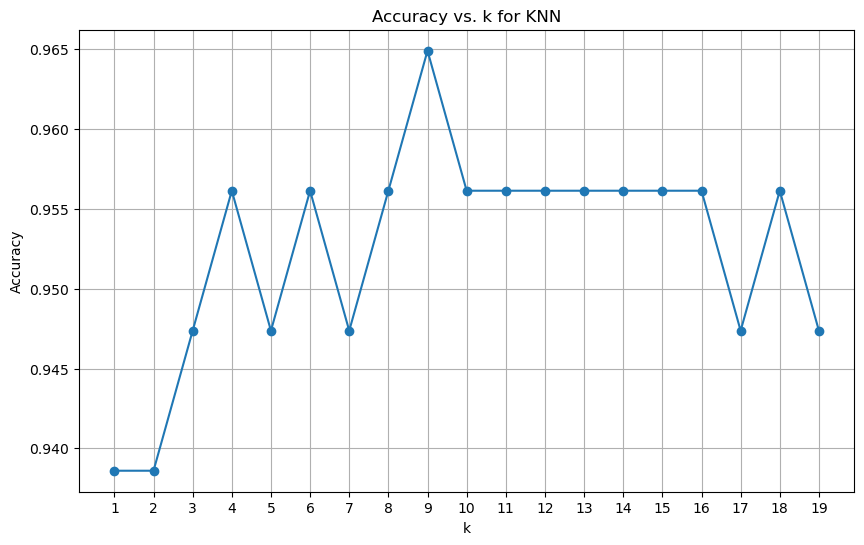

In [13]:
# Plotting code...
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('Accuracy vs. k for KNN')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

### Comparing against Sklearn's values

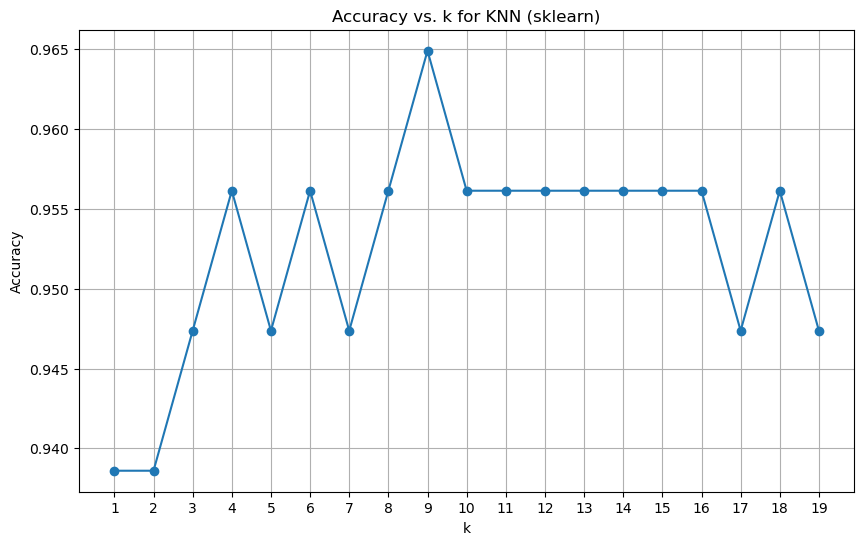

In [14]:
# Initialize the accuracies list
accuracies = []

# Range of k values to test
k_range = range(1, 20)

for k in k_range:
    # Create a KNeighborsClassifier instance with the current k value
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the classifier to the training data
    knn.fit(X_train_normalized, y_train)
    
    # Predict the labels for the test data
    y_pred = knn.predict(X_test_normalized)
    
    # Compute the accuracy and append it to the accuracies list
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('Accuracy vs. k for KNN (sklearn)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)  # Set x-axis ticks to natural numbers
plt.grid(True)
plt.show()

## Adding another dimension to the X train vector to vectorize the whole thing

We have a couple of vectors:

##### t = number of test samples
##### n = number of test features
##### m = number of train samples

$$
X_{test} = t \times n
$$

$$
X_{train} = m \times n
$$

$$
X_{trainNew} = t \times m \times n
$$

$$
d_{testTrain} = t \times m \times 1
$$

$$
d_{topK} = t \times k \times 1
$$

$$
y_{pred} = t \times 1
$$

In [15]:
k = 5
X_trainNew = X_train_normalized[np.newaxis, :, :] - X_test_normalized[:, np.newaxis, :]
d_testTrain = np.sqrt(np.sum(np.power(X_trainNew, 2), axis=2))

idxs = np.argsort(d_testTrain, axis=1)
y_train_casted = np.repeat(y_train.reshape(1, -1), X_trainNew.shape[0], axis=0)
y_train_sorted = np.take_along_axis(y_train_casted, idxs, axis=1)
y_train_topK = y_train_sorted[:, :k]

y_test_pred = np.apply_along_axis(
    lambda x: mode(x)[0],
    axis = 1,
    arr = y_train_topK
)

np.mean(y_test_pred == y_test)

0.9473684210526315

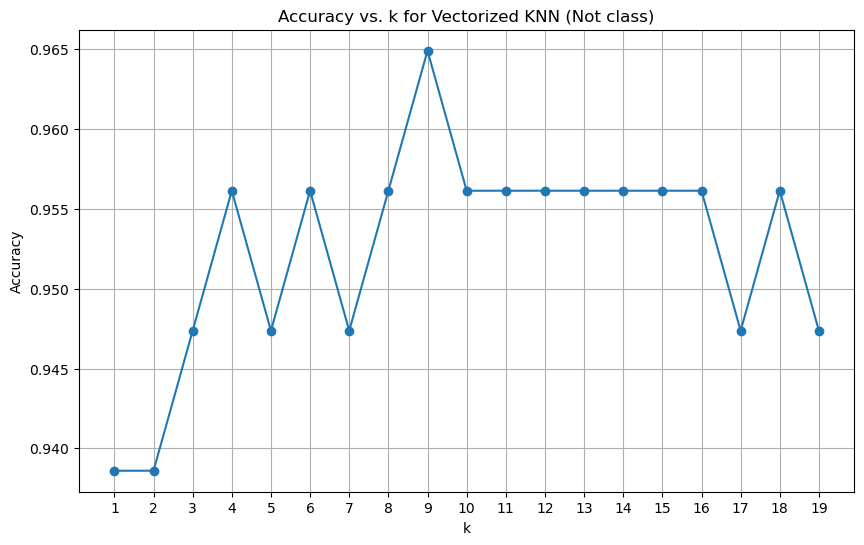

In [16]:
# Initialize the accuracies list
accuracies = []

# Range of k values to test
k_range = range(1, 20)

for k in k_range:
    X_trainNew = X_train_normalized[np.newaxis, :, :] - X_test_normalized[:, np.newaxis, :]
    d_testTrain = np.sqrt(np.sum(np.power(X_trainNew, 2), axis=2))
    
    idxs = np.argsort(d_testTrain, axis=1)
    y_train_casted = np.repeat(y_train.reshape(1, -1), X_trainNew.shape[0], axis=0)
    y_train_sorted = np.take_along_axis(y_train_casted, idxs, axis=1)
    y_train_topK = y_train_sorted[:, :k]
    
    y_test_pred = np.apply_along_axis(
        lambda x: mode(x)[0],
        axis = 1,
        arr = y_train_topK
    )
    
    # Compute the accuracy and append it to the accuracies list
    accuracy = np.mean(y_test_pred == y_test)
    accuracies.append(accuracy)

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('Accuracy vs. k for Vectorized KNN (Not class)')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)  # Set x-axis ticks to natural numbers
plt.grid(True)
plt.show()

## Implementing the highly vectorized KNN in another class (for benchmarking purposes)

In [17]:
class VectorizedKNNClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X_train, y_train):
        self._validate_input(X_train, y_train)
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        self._validate_input(X_test, None)

        X_trainNew = self.X_train[np.newaxis, :, :] - X_test[:, np.newaxis, :]
        d_testTrain = np.sqrt(np.sum(np.power(X_trainNew, 2), axis=2))
        idxs = np.argsort(d_testTrain, axis=1)

        y_train_casted = np.repeat(self.y_train.reshape(1, -1), X_trainNew.shape[0], axis=0)
        y_train_sorted = np.take_along_axis(y_train_casted, idxs, axis=1)
        y_train_topK = y_train_sorted[:, :self.k]

        y_test_pred = np.apply_along_axis(self._voting_func, axis=1, arr=y_train_topK)
        return y_test_pred

    def _validate_input(self, X, y=None):
        if not isinstance(X, np.ndarray):
            raise ValueError("Input data must be a NumPy array.")
        if y is not None and len(X) != len(y):
            raise ValueError("Number of samples in X and y must be equal.")

    def _voting_func(self, x):
        unique_labels, counts = np.unique(x, return_counts=True)
        max_count = np.max(counts)
        return unique_labels[np.argmax(counts)]

In [18]:
vectorizedKNN = VectorizedKNNClassifier(k=3)
vectorizedKNN.fit(X_train_normalized, y_train)
y_test_pred = vectorizedKNN.predict(X_test_normalized)
np.mean(y_test == y_test_pred)

0.9473684210526315

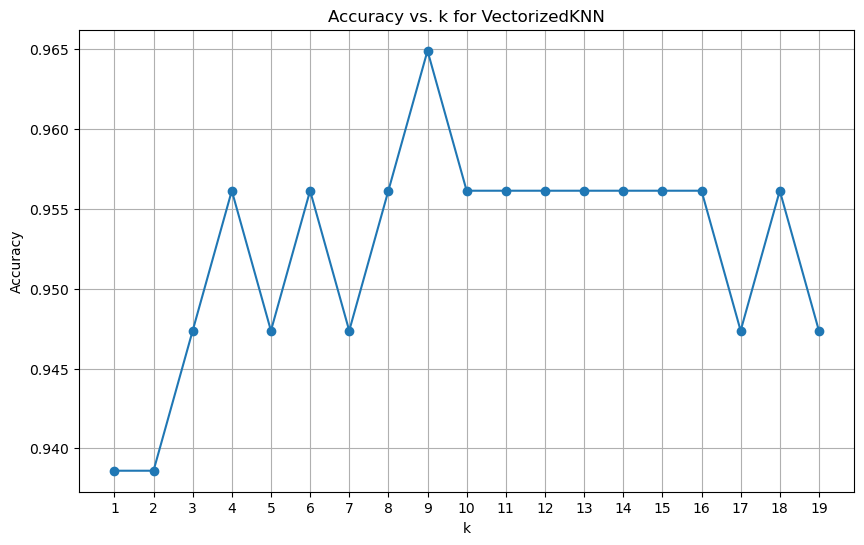

In [19]:
# Initialize the accuracies list
accuracies = []

# Range of k values to test
k_range = range(1, 20)

for k in k_range:
    vectorizedKNN = VectorizedKNNClassifier(k=k)
    vectorizedKNN.fit(X_train_normalized, y_train)
    y_pred = vectorizedKNN.predict(X_test_normalized)
    
    # Compute the accuracy and append it to the accuracies list
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('Accuracy vs. k for VectorizedKNN')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)  # Set x-axis ticks to natural numbers
plt.grid(True)
plt.show()

## Time Benchmarking

In [20]:
k = 3
vectorizedKNN = VectorizedKNNClassifier(k=k)
vectorizedKNN.fit(X_train_normalized, y_train)
KNNPredictor = MyKNN(
    X_train=X_train_normalized,
    y_train=y_train,
    k=k
)

In [21]:
print(f"KNNPredictor with for loop (k={k}): ")
%timeit -n 10 KNNPredictor.predict_dataset(X_test_normalized)

print(f"Vectorized KNN (k={k}): ")
%timeit -n 10 vectorizedKNN.predict(X_test_normalized)

KNNPredictor with for loop (k=3): 
12.7 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Vectorized KNN (k=3): 
76.7 ms ± 2.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
k = 15
vectorizedKNN = VectorizedKNNClassifier(k=k)
vectorizedKNN.fit(X_train_normalized, y_train)
KNNPredictor = MyKNN(
    X_train=X_train_normalized,
    y_train=y_train,
    k=k
)

In [23]:
print(f"KNNPredictor with for loop (k={k}): ")
%timeit -n 10 KNNPredictor.predict_dataset(X_test_normalized)

print(f"Vectorized KNN (k={k}): ")
%timeit -n 10 vectorizedKNN.predict(X_test_normalized)

KNNPredictor with for loop (k=15): 
10.9 ms ± 646 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Vectorized KNN (k=15): 
77.6 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### So k is not really effective on this thing. Let's make the training dataset a lot bigger!

In [24]:
k = 15
X_rand = np.random.rand(5000, 30)
y_rand = np.zeros((5000, 1))
X_rand = np.divide(np.subtract(X_rand, X_rand.mean()), X_rand.std())
X_rand_test = np.random.rand(50, 30)

vectorizedKNN = VectorizedKNNClassifier(k=k)
vectorizedKNN.fit(X_rand, y_rand)
KNNPredictor = MyKNN(
    X_train=X_rand,
    y_train=y_rand,
    k=k
)

In [25]:
print(f"KNNPredictor with for loop (k={k}): ")
%timeit -n 10 KNNPredictor.predict_dataset(X_rand_test)

print(f"Vectorized KNN (k={k}): ")
%timeit -n 10 vectorizedKNN.predict(X_rand_test)

KNNPredictor with for loop (k=15): 
80.7 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Vectorized KNN (k=15): 
380 ms ± 21.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### And finally, more features

In [26]:
X_test_normalized.shape

(114, 30)

In [27]:
k = 3
X_rand = np.random.rand(500, 300)
y_rand = np.zeros((500, 1))
X_rand = np.divide(np.subtract(X_rand, X_rand.mean()), X_rand.std())
X_rand_test = np.random.rand(120, 300)

vectorizedKNN = VectorizedKNNClassifier(k=k)
vectorizedKNN.fit(X_rand, y_rand)
KNNPredictor = MyKNN(
    X_train=X_rand,
    y_train=y_rand,
    k=k
)

(500, 300) (120, 300) (500, 1)


In [28]:
print(f"KNNPredictor with for loop (k={k}): ")
%timeit -n 10 KNNPredictor.predict_dataset(X_rand_test)

print(f"Vectorized KNN (k={k}): ")
%timeit -n 10 vectorizedKNN.predict(X_rand_test)

KNNPredictor with for loop (k=3): 
163 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Vectorized KNN (k=3): 
836 ms ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### How about more features, more samples in train and test, and a high k?

In [29]:
k = 21
X_rand = np.random.rand(5000, 300)
y_rand = np.zeros((5000, 1))
X_rand = np.divide(np.subtract(X_rand, X_rand.mean()), X_rand.std())
X_rand_test = np.random.rand(1000, 300)

vectorizedKNN = VectorizedKNNClassifier(k=k)
vectorizedKNN.fit(X_rand, y_rand)
KNNPredictor = MyKNN(
    X_train=X_rand,
    y_train=y_rand,
    k=k
)

In [31]:
print(f"KNNPredictor with for loop (k={k}): ")
%timeit -n 1 KNNPredictor.predict_dataset(X_rand_test)

print(f"Vectorized KNN (k={k}): ")
%timeit -n 1 vectorizedKNN.predict(X_rand_test)

KNNPredictor with for loop (k=21): 
15 s ± 1.88 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Vectorized KNN (k=21): 


MemoryError: Unable to allocate 11.2 GiB for an array with shape (1000, 5000, 300) and data type float64

And that's it! A complete benchmarking for differenct types of implementations for the KNN from scratch! (I even managed to crash the memory so YAY!